# COCO Reader

Reader operator that reads a COCO dataset (or subset of COCO), which consists of an annotation file and the images directory.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np
from time import time

subset = "val"
file_root = "/data/coco/coco-2017/coco2017/" + subset + "2017"
annotations_file = "/data/coco/coco-2017/coco2017/annotations/instances_" + subset + "2017.json"
num_gpus = 8
batch_size = 16

In [2]:
class COCOPipeline(Pipeline):                                                                    
    def __init__(self, batch_size, num_threads, device_id):                                       
        super(COCOPipeline, self).__init__(batch_size, num_threads, device_id, seed = 15)        
        self.input = ops.COCOReader(file_root = file_root, annotations_file = annotations_file,
                                     shard_id = device_id, num_shards = num_gpus)
        self.decode = ops.nvJPEGDecoder(device = "mixed", output_type = types.RGB)                        
                                                                                                  
    def define_graph(self):                                                                       
        inputs, bboxes = self.input()            
        images = self.decode(inputs)                                                                                                      
        return (images, bboxes)                                                         

In [3]:
start = time()
pipes = [COCOPipeline(batch_size=batch_size, num_threads=2, device_id = device_id)  for device_id in range(num_gpus)]
for pipe in pipes:
    pipe.build()
total_time = time() - start
print("Computation graph built and dataset loaded in %f seconds." % total_time)

Computation graph built and dataset loaded in 9.724077 seconds.


In [4]:
pipe_out = [pipe.run() for pipe in pipes]                                                   

images_cpu = pipe_out[0][0].asCPU()
bboxes_cpu = pipe_out[0][1]

Bounding boxes returned by the operator are lists of floats containing 5 elements:
\[x, y, width, height, category_id]

In [5]:
bboxes = bboxes_cpu.at(4)
bboxes

array([[187.74,   5.84, 310.4 , 380.49,   2.  ],
       [398.03,  80.69,  81.12,  36.8 ,   3.  ],
       [148.45,  71.56,  92.  ,  44.27,   3.  ],
       [109.26,  26.54,   8.59,  11.57,  10.  ],
       [ 95.07,  67.63,   6.89,   8.34,  10.  ],
       [364.21,  86.57,  31.29,  23.67,   3.  ],
       [ 81.28,  76.22,  26.81,  18.31,   3.  ],
       [122.6 ,  79.2 ,   9.33,  14.9 ,   3.  ],
       [506.05,  25.26, 133.95, 111.97,   8.  ],
       [396.71,  80.69,  82.13,  35.56,   8.  ],
       [476.76,  81.15,  43.64,  39.47,   8.  ],
       [ 32.65,  58.41,   5.23,   3.45,  10.  ]], dtype=float32)

Let's see the ground truth bounding boxes drawn on the image.

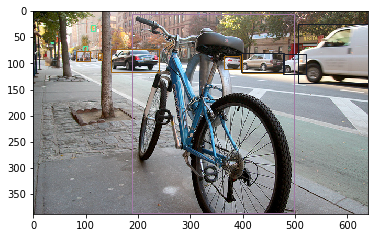

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

img_index = 4

img = images_cpu.at(img_index)

fig,ax = plt.subplots(1)

ax.imshow(img)
bboxes = bboxes_cpu.at(img_index)
categories_set = set()
for bbox in bboxes:
    categories_set.add(int(bbox[4]))

category_id_to_color = dict([ (cat_id , [random.uniform(0, 1) ,random.uniform(0, 1), random.uniform(0, 1)]) for cat_id in categories_set])

for bbox in bboxes:
    category_id = int(bbox[4])
    rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor=category_id_to_color[category_id],facecolor='none')
    ax.add_patch(rect)

plt.show()
